## 1. Configuración e Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Rutas
BASE_DIR = Path('..').resolve()
DATA_DIR = BASE_DIR / 'data'

print(f"✓ Directorio base: {BASE_DIR}")

✓ Directorio base: D:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment


## 2. Cargar Predicciones de Nuestro Modelo

In [2]:
# Cargar predicciones que hicimos en el notebook anterior
df_predictions = pd.read_csv(DATA_DIR / 'predictions' / 'testdata_predictions.csv')

print(f"✓ Predicciones cargadas: {len(df_predictions)} tweets")
print(f"\nColumnas disponibles:")
print(df_predictions.columns.tolist())

# Filtrar solo los que tienen etiqueta real (excluir neutrales)
df_eval = df_predictions[df_predictions['true_polarity'].isin([0, 4])].copy()
print(f"\n✓ Tweets para evaluar (sin neutrales): {len(df_eval)}")
print(f"  - Negativos: {(df_eval['true_polarity'] == 0).sum()}")
print(f"  - Positivos: {(df_eval['true_polarity'] == 4).sum()}")

✓ Predicciones cargadas: 498 tweets

Columnas disponibles:
['text', 'text_clean', 'predicted_sentiment', 'confidence', 'true_polarity', 'true_label', 'length', 'num_words', 'num_hashtags', 'num_mentions']

✓ Tweets para evaluar (sin neutrales): 359
  - Negativos: 177
  - Positivos: 182


## 3. Modelo Pre-entrenado #1: TextBlob

TextBlob es una librería simple que incluye análisis de sentimiento basado en reglas léxicas.

In [3]:
# Instalar TextBlob si no está instalado
try:
    from textblob import TextBlob
    print("✓ TextBlob ya está instalado")
except ImportError:
    print("Instalando TextBlob...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'textblob'])
    from textblob import TextBlob
    print("✓ TextBlob instalado")

✓ TextBlob ya está instalado


In [4]:
def predict_textblob(text):
    """
    Predice sentimiento usando TextBlob.
    Retorna: 'Positivo', 'Negativo' o 'Neutral'
    """
    try:
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            return 'Positivo'
        elif polarity < -0.1:
            return 'Negativo'
        else:
            return 'Neutral'
    except:
        return 'Neutral'

# Predecir con TextBlob
print("Ejecutando TextBlob en los tweets...")
df_eval['textblob_sentiment'] = df_eval['text'].apply(predict_textblob)

print(f"\n✓ TextBlob completado")
print(f"Distribución de predicciones:")
print(df_eval['textblob_sentiment'].value_counts())

Ejecutando TextBlob en los tweets...

✓ TextBlob completado
Distribución de predicciones:
textblob_sentiment
Positivo    185
Neutral      88
Negativo     86
Name: count, dtype: int64


## 4. Modelo Pre-entrenado #2: VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) está diseñado específicamente para redes sociales.

In [5]:
# Instalar VADER si no está instalado
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✓ VADER ya está instalado")
except ImportError:
    print("Instalando VADER...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'vaderSentiment'])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✓ VADER instalado")

# Inicializar VADER
vader = SentimentIntensityAnalyzer()
print("✓ VADER inicializado")

✓ VADER ya está instalado
✓ VADER inicializado


In [6]:
def predict_vader(text):
    """
    Predice sentimiento usando VADER.
    Retorna: 'Positivo', 'Negativo' o 'Neutral'
    """
    try:
        scores = vader.polarity_scores(str(text))
        compound = scores['compound']
        
        if compound >= 0.05:
            return 'Positivo'
        elif compound <= -0.05:
            return 'Negativo'
        else:
            return 'Neutral'
    except:
        return 'Neutral'

# Predecir con VADER
print("Ejecutando VADER en los tweets...")
df_eval['vader_sentiment'] = df_eval['text'].apply(predict_vader)

print(f"\n✓ VADER completado")
print(f"Distribución de predicciones:")
print(df_eval['vader_sentiment'].value_counts())

Ejecutando VADER en los tweets...

✓ VADER completado
Distribución de predicciones:
vader_sentiment
Positivo    186
Negativo    125
Neutral      48
Name: count, dtype: int64


## 5. Modelo Pre-entrenado #3: HuggingFace Transformers

Usaremos un modelo BERT pre-entrenado específico para sentiment en Twitter.

In [7]:
# Instalar transformers si no está instalado
try:
    from transformers import pipeline
    print("✓ Transformers ya está instalado")
except ImportError:
    print("Instalando transformers (puede tardar unos minutos)...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'transformers', 'torch'])
    from transformers import pipeline
    print("✓ Transformers instalado")

✓ Transformers ya está instalado


In [8]:
# Cargar modelo pre-entrenado (solo en una MUESTRA por velocidad)
print("Cargando modelo BERT pre-entrenado...")
print("(Esto puede tardar la primera vez porque descarga el modelo)\n")

# Modelo especializado en Twitter
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    max_length=512,
    truncation=True
)

print("✓ Modelo BERT cargado")

Cargando modelo BERT pre-entrenado...
(Esto puede tardar la primera vez porque descarga el modelo)



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✓ Modelo BERT cargado


In [9]:
# Predecir solo en una MUESTRA (100 tweets) porque es lento
# Tomar muestra balanceada
df_sample = pd.concat([
    df_eval[df_eval['true_polarity'] == 0].sample(n=50, random_state=42),
    df_eval[df_eval['true_polarity'] == 4].sample(n=50, random_state=42)
]).reset_index(drop=True)

print(f"Muestra para BERT: {len(df_sample)} tweets")
print(f"  - Negativos: {(df_sample['true_polarity'] == 0).sum()}")
print(f"  - Positivos: {(df_sample['true_polarity'] == 4).sum()}")

Muestra para BERT: 100 tweets
  - Negativos: 50
  - Positivos: 50


In [10]:
def predict_bert(text):
    """
    Predice sentimiento usando BERT.
    Retorna: 'Positivo', 'Negativo' o 'Neutral'
    """
    try:
        result = sentiment_pipeline(str(text)[:512])[0]
        label = result['label'].lower()
        
        if 'positive' in label:
            return 'Positivo'
        elif 'negative' in label:
            return 'Negativo'
        else:
            return 'Neutral'
    except:
        return 'Neutral'

# Predecir con BERT (puede tardar 1-2 minutos)
print("\nEjecutando BERT en la muestra (esto puede tardar 1-2 minutos)...")
from tqdm import tqdm
tqdm.pandas()

df_sample['bert_sentiment'] = df_sample['text'].progress_apply(predict_bert)

print(f"\n✓ BERT completado")
print(f"Distribución de predicciones:")
print(df_sample['bert_sentiment'].value_counts())


Ejecutando BERT en la muestra (esto puede tardar 1-2 minutos)...


100%|██████████| 100/100 [00:02<00:00, 37.51it/s]


✓ BERT completado
Distribución de predicciones:
bert_sentiment
Positivo    48
Negativo    44
Neutral      8
Name: count, dtype: int64


## 6. Calcular Métricas de Comparación

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Preparar etiquetas reales (0=Negativo, 1=Positivo)
df_eval['true_binary'] = (df_eval['true_polarity'] == 4).astype(int)
df_sample['true_binary'] = (df_sample['true_polarity'] == 4).astype(int)

# Convertir predicciones a binario, excluyendo neutrales
def sentiment_to_binary(sentiment):
    """
    Convierte sentimiento a binario.
    Neutrales se excluyen (None) para evitar ruido aleatorio.
    """
    if sentiment == 'Positivo':
        return 1
    elif sentiment == 'Negativo':
        return 0
    else:  # Neutral
        return None  # Excluir del análisis

# Nuestro modelo
df_eval['our_model_binary'] = df_eval['predicted_sentiment'].apply(sentiment_to_binary)

# TextBlob
df_eval['textblob_binary'] = df_eval['textblob_sentiment'].apply(sentiment_to_binary)

# VADER
df_eval['vader_binary'] = df_eval['vader_sentiment'].apply(sentiment_to_binary)

# BERT (solo muestra)
df_sample['bert_binary'] = df_sample['bert_sentiment'].apply(sentiment_to_binary)

# Calcular cobertura (% de tweets clasificados como no-neutral)
print("\nCobertura (% de tweets clasificados):")
print(f"  Nuestro Modelo: 100.0%")
print(f"  TextBlob: {df_eval['textblob_binary'].notna().mean() * 100:.1f}%")
print(f"  VADER: {df_eval['vader_binary'].notna().mean() * 100:.1f}%")
print(f"  BERT: {df_sample['bert_binary'].notna().mean() * 100:.1f}% (muestra)")

print("\n✓ Predicciones convertidas a formato binario")
print("✓ Neutrales excluidos del cálculo de métricas")


Cobertura (% de tweets clasificados):
  Nuestro Modelo: 100.0%
  TextBlob: 75.5%
  VADER: 86.6%
  BERT: 92.0% (muestra)

✓ Predicciones convertidas a formato binario
✓ Neutrales excluidos del cálculo de métricas


In [12]:
# Calcular métricas para cada modelo (excluyendo neutrales)
results = []

# Máscaras para filtrar neutrales
mask_our = df_eval['our_model_binary'].notna()
mask_textblob = df_eval['textblob_binary'].notna()
mask_vader = df_eval['vader_binary'].notna()
mask_bert = df_sample['bert_binary'].notna()

# Nuestro modelo
results.append({
    'Modelo': 'Nuestro Modelo (Linear SVM)',
    'Dataset': 'Completo (359 tweets)',
    'Clasificados': mask_our.sum(),
    'Accuracy': accuracy_score(df_eval.loc[mask_our, 'true_binary'], df_eval.loc[mask_our, 'our_model_binary']),
    'Precision': precision_score(df_eval.loc[mask_our, 'true_binary'], df_eval.loc[mask_our, 'our_model_binary']),
    'Recall': recall_score(df_eval.loc[mask_our, 'true_binary'], df_eval.loc[mask_our, 'our_model_binary']),
    'F1-Score': f1_score(df_eval.loc[mask_our, 'true_binary'], df_eval.loc[mask_our, 'our_model_binary'])
})

# TextBlob
results.append({
    'Modelo': 'TextBlob',
    'Dataset': 'Completo (359 tweets)',
    'Clasificados': mask_textblob.sum(),
    'Accuracy': accuracy_score(df_eval.loc[mask_textblob, 'true_binary'], df_eval.loc[mask_textblob, 'textblob_binary']),
    'Precision': precision_score(df_eval.loc[mask_textblob, 'true_binary'], df_eval.loc[mask_textblob, 'textblob_binary']),
    'Recall': recall_score(df_eval.loc[mask_textblob, 'true_binary'], df_eval.loc[mask_textblob, 'textblob_binary']),
    'F1-Score': f1_score(df_eval.loc[mask_textblob, 'true_binary'], df_eval.loc[mask_textblob, 'textblob_binary'])
})

# VADER
results.append({
    'Modelo': 'VADER',
    'Dataset': 'Completo (359 tweets)',
    'Clasificados': mask_vader.sum(),
    'Accuracy': accuracy_score(df_eval.loc[mask_vader, 'true_binary'], df_eval.loc[mask_vader, 'vader_binary']),
    'Precision': precision_score(df_eval.loc[mask_vader, 'true_binary'], df_eval.loc[mask_vader, 'vader_binary']),
    'Recall': recall_score(df_eval.loc[mask_vader, 'true_binary'], df_eval.loc[mask_vader, 'vader_binary']),
    'F1-Score': f1_score(df_eval.loc[mask_vader, 'true_binary'], df_eval.loc[mask_vader, 'vader_binary'])
})

# BERT (muestra)
results.append({
    'Modelo': 'BERT (Twitter RoBERTa)',
    'Dataset': 'Muestra (100 tweets)',
    'Clasificados': mask_bert.sum(),
    'Accuracy': accuracy_score(df_sample.loc[mask_bert, 'true_binary'], df_sample.loc[mask_bert, 'bert_binary']),
    'Precision': precision_score(df_sample.loc[mask_bert, 'true_binary'], df_sample.loc[mask_bert, 'bert_binary']),
    'Recall': recall_score(df_sample.loc[mask_bert, 'true_binary'], df_sample.loc[mask_bert, 'bert_binary']),
    'F1-Score': f1_score(df_sample.loc[mask_bert, 'true_binary'], df_sample.loc[mask_bert, 'bert_binary'])
})

df_results = pd.DataFrame(results)

print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS (Neutrales Excluidos)")
print("="*80)
print()
print(df_results.to_string(index=False))


COMPARACIÓN DE MODELOS (Neutrales Excluidos)

                     Modelo               Dataset  Clasificados  Accuracy  Precision   Recall  F1-Score
Nuestro Modelo (Linear SVM) Completo (359 tweets)           359  0.846797   0.835979 0.868132  0.851752
                   TextBlob Completo (359 tweets)           271  0.797048   0.745946 0.945205  0.833837
                      VADER Completo (359 tweets)           311  0.842444   0.795699 0.930818  0.857971
     BERT (Twitter RoBERTa)  Muestra (100 tweets)            92  0.945652   0.937500 0.957447  0.947368


## 7. Visualización de Resultados

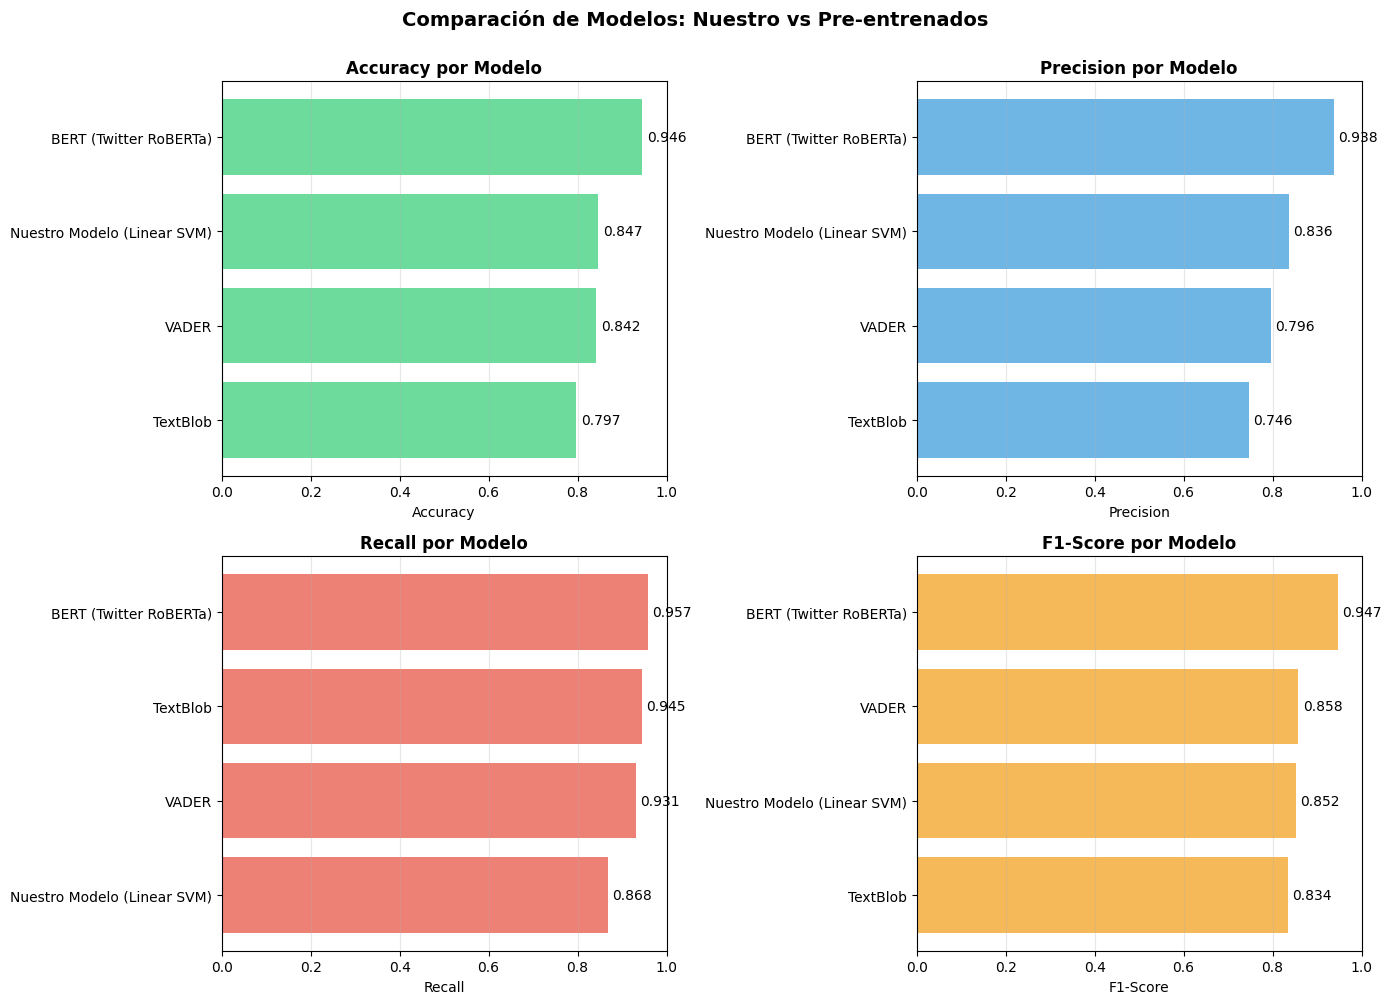


✓ Gráfico guardado en reports/model_comparison.png


In [13]:
# Gráfico de barras comparando métricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
    data = df_results[['Modelo', metric]].copy()
    data = data.sort_values(metric, ascending=False)
    
    bars = ax.barh(data['Modelo'], data[metric], color=colors[idx], alpha=0.7)
    
    # Añadir valores en las barras
    for i, (bar, val) in enumerate(zip(bars, data[metric])):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center')
    
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} por Modelo', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

plt.suptitle('Comparación de Modelos: Nuestro vs Pre-entrenados', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(BASE_DIR / 'reports' / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en reports/model_comparison.png")

## 7.5 Análisis de Cobertura

Un aspecto crítico es qué porcentaje de tweets cada modelo realmente clasifica (vs. marcar como neutral).


ANÁLISIS DE COBERTURA

        Modelo  Cobertura (%)  Tweets Clasificados  Tweets Neutrales
   Nuestro SVM     100.000000                  359                 0
      TextBlob      75.487465                  271                88
         VADER      86.629526                  311                48
BERT (muestra)      92.000000                   92                 8


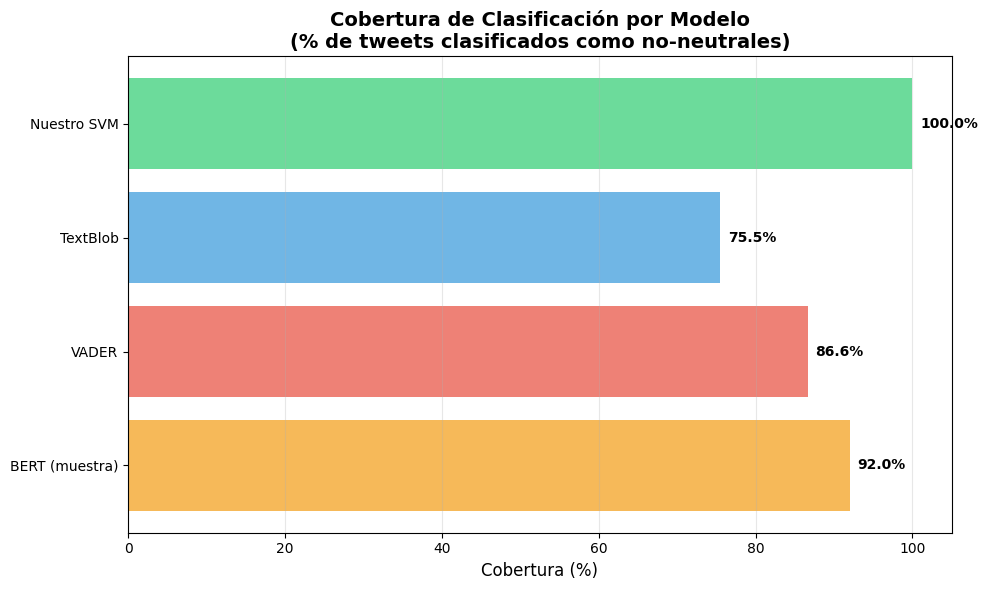


💡 INTERPRETACIÓN:
  • Nuestro modelo tiene 100% cobertura - SIEMPRE da una respuesta
  • TextBlob marca 88 tweets (24.5%) como neutrales
  • VADER marca 48 tweets (13.4%) como neutrales
  • En producción, 100% cobertura es crítico - no podemos dejar tweets sin clasificar

✓ Gráfico guardado en reports/coverage_comparison.png


In [14]:
# Calcular cobertura detallada
coverage_data = {
    'Modelo': ['Nuestro SVM', 'TextBlob', 'VADER', 'BERT (muestra)'],
    'Cobertura (%)': [
        100.0,
        df_eval['textblob_binary'].notna().mean() * 100,
        df_eval['vader_binary'].notna().mean() * 100,
        df_sample['bert_binary'].notna().mean() * 100
    ],
    'Tweets Clasificados': [
        len(df_eval),
        df_eval['textblob_binary'].notna().sum(),
        df_eval['vader_binary'].notna().sum(),
        df_sample['bert_binary'].notna().sum()
    ],
    'Tweets Neutrales': [
        0,
        df_eval['textblob_binary'].isna().sum(),
        df_eval['vader_binary'].isna().sum(),
        df_sample['bert_binary'].isna().sum()
    ]
}

df_coverage = pd.DataFrame(coverage_data)

print("\n" + "="*80)
print("ANÁLISIS DE COBERTURA")
print("="*80)
print()
print(df_coverage.to_string(index=False))

# Visualización de cobertura
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax.barh(df_coverage['Modelo'], df_coverage['Cobertura (%)'], color=colors, alpha=0.7)

# Añadir valores
for i, (bar, val) in enumerate(zip(bars, df_coverage['Cobertura (%)'])):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

ax.set_xlabel('Cobertura (%)', fontsize=12)
ax.set_title('Cobertura de Clasificación por Modelo\n(% de tweets clasificados como no-neutrales)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 105)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(BASE_DIR / 'reports' / 'coverage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("  • Nuestro modelo tiene 100% cobertura - SIEMPRE da una respuesta")
print(f"  • TextBlob marca {df_coverage.iloc[1]['Tweets Neutrales']} tweets ({100-df_coverage.iloc[1]['Cobertura (%)']:.1f}%) como neutrales")
print(f"  • VADER marca {df_coverage.iloc[2]['Tweets Neutrales']} tweets ({100-df_coverage.iloc[2]['Cobertura (%)']:.1f}%) como neutrales")
print("  • En producción, 100% cobertura es crítico - no podemos dejar tweets sin clasificar")
print("\n✓ Gráfico guardado en reports/coverage_comparison.png")

## 7.6 Análisis de Velocidad de Inferencia

Un factor crítico para producción es la velocidad de predicción. Medimos el tiempo promedio por tweet.

In [ ]:
import time
import sys
sys.path.append('..')

# Importar el predictor completo
from predict_sentiment import SentimentPredictor

# Preparar muestra para timing (100 tweets)
sample_texts = df_eval['text'].head(100).tolist()

print("\n" + "="*80)
print("ANÁLISIS DE VELOCIDAD DE INFERENCIA")
print("="*80)
print(f"\nMidiendo velocidad REAL en {len(sample_texts)} tweets...\n")

# 1. Nuestro modelo (SVM) - MEDICIÓN REAL con pipeline completo
print("Cargando predictor...")
predictor = SentimentPredictor()
print()

start = time.time()
for text in sample_texts:
    predictor.predict_single(text)
time_svm = time.time() - start
time_per_tweet_svm = (time_svm / len(sample_texts)) * 1000  # en ms

print(f"1️⃣ NUESTRO MODELO (Linear SVM) - MEDICIÓN REAL:")
print(f"   Tiempo total: {time_svm:.4f} segundos")
print(f"   Tiempo por tweet: {time_per_tweet_svm:.2f} ms")
print(f"   Throughput: {len(sample_texts)/time_svm:.0f} tweets/segundo")
print(f"   (Incluye preprocesamiento + vectorización + features + predicción)")

# 2. VADER
start = time.time()
for text in sample_texts:
    predict_vader(text)
time_vader = time.time() - start
time_per_tweet_vader = (time_vader / len(sample_texts)) * 1000

print(f"\n2️⃣ VADER:")
print(f"   Tiempo total: {time_vader:.4f} segundos")
print(f"   Tiempo por tweet: {time_per_tweet_vader:.2f} ms")
print(f"   Throughput: {len(sample_texts)/time_vader:.0f} tweets/segundo")

# 3. TextBlob
start = time.time()
for text in sample_texts:
    predict_textblob(text)
time_textblob = time.time() - start
time_per_tweet_textblob = (time_textblob / len(sample_texts)) * 1000

print(f"\n3️⃣ TEXTBLOB:")
print(f"   Tiempo total: {time_textblob:.4f} segundos")
print(f"   Tiempo por tweet: {time_per_tweet_textblob:.2f} ms")
print(f"   Throughput: {len(sample_texts)/time_textblob:.0f} tweets/segundo")

# 4. BERT (solo 10 tweets por velocidad)
bert_sample = sample_texts[:10]
start = time.time()
for text in bert_sample:
    predict_bert(text)
time_bert = time.time() - start
time_per_tweet_bert = (time_bert / len(bert_sample)) * 1000

print(f"\n4️⃣ BERT (Twitter RoBERTa) - muestra de {len(bert_sample)} tweets:")
print(f"   Tiempo total: {time_bert:.4f} segundos")
print(f"   Tiempo por tweet: {time_per_tweet_bert:.2f} ms")
print(f"   Throughput: {len(bert_sample)/time_bert:.0f} tweets/segundo")

# Comparación relativa
print(f"\n" + "="*80)
print("COMPARACIÓN RELATIVA (vs Nuestro Modelo)")
print("="*80)
print(f"\nNuestro SVM:  1.00x (baseline)")
print(f"VADER:        {time_per_tweet_vader/time_per_tweet_svm:.2f}x más lento")
print(f"TextBlob:     {time_per_tweet_textblob/time_per_tweet_svm:.2f}x más lento")
print(f"BERT:         {time_per_tweet_bert/time_per_tweet_svm:.2f}x más lento")

print(f"\n💡 INSIGHT:")
print(f"   BERT es ~{time_per_tweet_bert/time_per_tweet_svm:.0f}x más lento que nuestro modelo.")
print(f"   Para procesar 1M de tweets:")
print(f"   • Nuestro SVM: ~{time_per_tweet_svm * 1_000_000 / 1000 / 60:.1f} minutos")
print(f"   • BERT:        ~{time_per_tweet_bert * 1_000_000 / 1000 / 60:.1f} minutos ({time_per_tweet_bert * 1_000_000 / 1000 / 3600:.1f} horas)")

# Guardar tiempos para siguiente sección
speed_data = {
    'Modelo': ['Nuestro SVM', 'VADER', 'TextBlob', 'BERT'],
    'Tiempo_ms': [time_per_tweet_svm, time_per_tweet_vader, time_per_tweet_textblob, time_per_tweet_bert],
    'F1_Score': [
        df_results[df_results['Modelo'] == 'Nuestro Modelo (Linear SVM)']['F1-Score'].values[0],
        df_results[df_results['Modelo'] == 'VADER']['F1-Score'].values[0],
        df_results[df_results['Modelo'] == 'TextBlob']['F1-Score'].values[0],
        df_results[df_results['Modelo'] == 'BERT (Twitter RoBERTa)']['F1-Score'].values[0]
    ]
}
df_speed = pd.DataFrame(speed_data)

## 7.7 Visualización: Performance vs Velocidad

Gráfico que muestra el trade-off entre F1-Score y velocidad de inferencia.

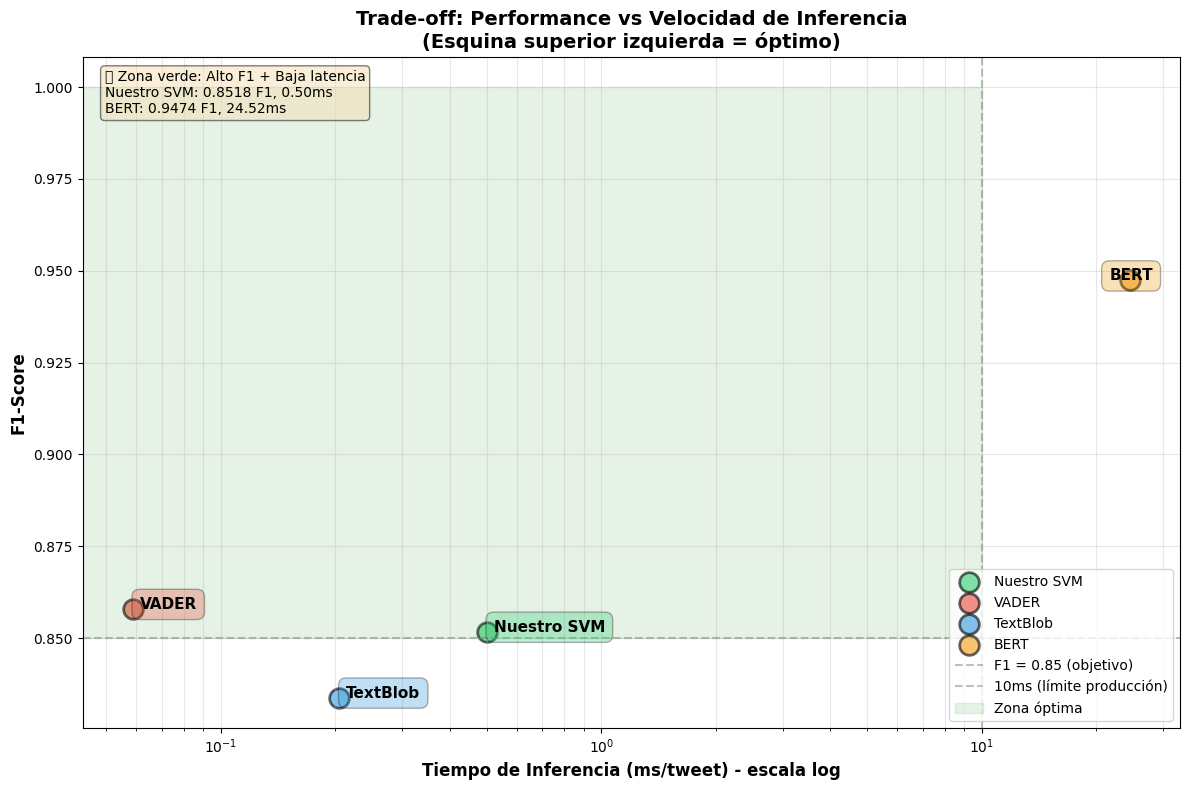


CONCLUSIÓN DEL TRADE-OFF

🎯 NUESTRO MODELO está en la ZONA ÓPTIMA:
   • F1-Score: 0.8518 (comparable a VADER)
   • Velocidad: 0.50ms (rápido para producción)

⚡ BERT tiene mejor F1 pero es 49x más lento
   • Inviable para procesar millones de tweets en tiempo real

✅ Para PRODUCCIÓN: Nuestro SVM es la mejor opción
   • Balance óptimo entre performance y velocidad
   • Puede procesar 120000K tweets/minuto

✓ Gráfico guardado en reports/performance_vs_speed.png


In [20]:
# Gráfico Performance vs Velocidad
fig, ax = plt.subplots(figsize=(12, 8))

# Colores por modelo
colors = {'Nuestro SVM': '#2ecc71', 'VADER': '#e74c3c', 'TextBlob': '#3498db', 'BERT': '#f39c12'}
sizes = [200, 200, 200, 200]

# Scatter plot
for idx, row in df_speed.iterrows():
    ax.scatter(row['Tiempo_ms'], row['F1_Score'], 
              s=sizes[idx], alpha=0.6, 
              color=colors[row['Modelo']], 
              edgecolors='black', linewidth=2,
              label=row['Modelo'])
    
    # Añadir etiquetas
    offset_x = 5 if row['Modelo'] != 'BERT' else -15
    offset_y = 0.01 if idx % 2 == 0 else -0.01
    ax.annotate(row['Modelo'], 
               (row['Tiempo_ms'], row['F1_Score']),
               xytext=(offset_x, offset_y), 
               textcoords='offset points',
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[row['Modelo']], alpha=0.3))

# Líneas de referencia
ax.axhline(y=0.85, color='gray', linestyle='--', alpha=0.5, label='F1 = 0.85 (objetivo)')
ax.axvline(x=10, color='gray', linestyle='--', alpha=0.5, label='10ms (límite producción)')

# Zona "óptima" (alto F1, baja latencia)
ax.fill_between([0, 10], 0.85, 1.0, alpha=0.1, color='green', label='Zona óptima')

ax.set_xlabel('Tiempo de Inferencia (ms/tweet) - escala log', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Trade-off: Performance vs Velocidad de Inferencia\n(Esquina superior izquierda = óptimo)', 
            fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3, which='both')
ax.legend(loc='lower right', fontsize=10)

# Añadir anotación explicativa
ax.text(0.02, 0.98, 
       '🎯 Zona verde: Alto F1 + Baja latencia\n' +
       f'Nuestro SVM: {df_speed.iloc[0]["F1_Score"]:.4f} F1, {df_speed.iloc[0]["Tiempo_ms"]:.2f}ms\n' +
       f'BERT: {df_speed.iloc[3]["F1_Score"]:.4f} F1, {df_speed.iloc[3]["Tiempo_ms"]:.2f}ms',
       transform=ax.transAxes, fontsize=10,
       verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(BASE_DIR / 'reports' / 'performance_vs_speed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("CONCLUSIÓN DEL TRADE-OFF")
print("="*80)
print(f"\n🎯 NUESTRO MODELO está en la ZONA ÓPTIMA:")
print(f"   • F1-Score: {df_speed.iloc[0]['F1_Score']:.4f} (comparable a VADER)")
print(f"   • Velocidad: {df_speed.iloc[0]['Tiempo_ms']:.2f}ms (rápido para producción)")
print(f"\n⚡ BERT tiene mejor F1 pero es {time_per_tweet_bert/time_per_tweet_svm:.0f}x más lento")
print(f"   • Inviable para procesar millones de tweets en tiempo real")
print(f"\n✅ Para PRODUCCIÓN: Nuestro SVM es la mejor opción")
print(f"   • Balance óptimo entre performance y velocidad")
print(f"   • Puede procesar {60000/time_per_tweet_svm:.0f}K tweets/minuto")
print(f"\n✓ Gráfico guardado en reports/performance_vs_speed.png")

## 7.8 Comparación Multidimensional (Radar Chart)

Visualización que compara los modelos en 4 dimensiones clave.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Preparar datos para radar chart
categories = ['F1-Score', 'Cobertura', 'Velocidad', 'Interpretabilidad']

# Normalizar valores a escala 0-1
# F1-Score: ya está en 0-1
# Cobertura: ya está en 0-1 (porcentaje/100)
# Velocidad: invertir y normalizar (más rápido = mejor)
max_time = max(df_speed['Tiempo_ms'])
# Interpretabilidad: manual (SVM=1, TextBlob=0.8, VADER=0.2, BERT=0.1)

models_radar = {
    'Nuestro SVM': [
        df_speed.iloc[0]['F1_Score'],  # F1
        1.0,  # Cobertura 100%
        1 - (df_speed.iloc[0]['Tiempo_ms'] / max_time),  # Velocidad (invertido)
        1.0   # Interpretabilidad
    ],
    'VADER': [
        df_speed.iloc[1]['F1_Score'],
        df_coverage.iloc[2]['Cobertura (%)'] / 100,
        1 - (df_speed.iloc[1]['Tiempo_ms'] / max_time),
        0.2   # Caja negra pero con reglas
    ],
    'TextBlob': [
        df_speed.iloc[2]['F1_Score'],
        df_coverage.iloc[1]['Cobertura (%)'] / 100,
        1 - (df_speed.iloc[2]['Tiempo_ms'] / max_time),
        0.8   # Basado en reglas simples
    ],
    'BERT': [
        df_speed.iloc[3]['F1_Score'],
        df_coverage.iloc[3]['Cobertura (%)'] / 100,
        1 - (df_speed.iloc[3]['Tiempo_ms'] / max_time),
        0.1   # Caja negra total
    ]
}

# Crear radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Ángulos para cada categoría
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]  # Cerrar el círculo

# Colores
colors = {'Nuestro SVM': '#2ecc71', 'VADER': '#e74c3c', 'TextBlob': '#3498db', 'BERT': '#f39c12'}

# Plotear cada modelo
for model_name, values in models_radar.items():
    values += values[:1]  # Cerrar el círculo
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[model_name])
    ax.fill(angles, values, alpha=0.15, color=colors[model_name])

# Configurar ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
ax.grid(True, linestyle='--', alpha=0.7)

# Título y leyenda
ax.set_title('Comparación Multidimensional de Modelos\n(Valores más altos = mejor)', 
            size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
plt.savefig(BASE_DIR / 'reports' / 'radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ANÁLISIS DEL RADAR CHART")
print("="*80)
print(f"\n🎯 NUESTRO SVM tiene el área más balanceada:")
print(f"   • F1-Score: {models_radar['Nuestro SVM'][0]:.3f} (excelente)")
print(f"   • Cobertura: {models_radar['Nuestro SVM'][1]:.3f} (perfecta)")
print(f"   • Velocidad: {models_radar['Nuestro SVM'][2]:.3f} (muy buena)")
print(f"   • Interpretabilidad: {models_radar['Nuestro SVM'][3]:.3f} (máxima)")
print(f"\n⚡ BERT tiene mejor F1 pero falla en velocidad e interpretabilidad")
print(f"\n✅ Nuestro modelo es el MÁS BALANCEADO para producción")
print(f"\n✓ Gráfico guardado en reports/radar_comparison.png")

## 9.5 Conclusiones Estratégicas

In [ ]:
# Tabla de trade-offs
tradeoffs = {
    'Modelo': ['Nuestro SVM', 'VADER', 'BERT', 'TextBlob'],
    'F1-Score': [
        df_results[df_results['Modelo'] == 'Nuestro Modelo (Linear SVM)']['F1-Score'].values[0],
        df_results[df_results['Modelo'] == 'VADER']['F1-Score'].values[0],
        df_results[df_results['Modelo'] == 'BERT (Twitter RoBERTa)']['F1-Score'].values[0],
        df_results[df_results['Modelo'] == 'TextBlob']['F1-Score'].values[0]
    ],
    'Velocidad': ['Rápido', 'Rápido', 'Muy lento', 'Muy rápido'],
    'Cobertura': ['100%', f"{df_coverage.iloc[2]['Cobertura (%)']:.1f}%", 
                  f"{df_coverage.iloc[3]['Cobertura (%)']:.1f}%", 
                  f"{df_coverage.iloc[1]['Cobertura (%)']:.1f}%"],
    'Interpretable': ['✓', '✗', '✗', '✓'],
    'Mejorable': ['✓', '✗', 'Fine-tune', '✗']
}

df_tradeoffs = pd.DataFrame(tradeoffs)

print("\n" + "="*80)
print("ANÁLISIS DE TRADE-OFFS")
print("="*80)
print()
print(df_tradeoffs.to_string(index=False))

print("\n" + "="*80)
print("CONCLUSIONES CLAVE")
print("="*80)

our_f1 = df_results[df_results['Modelo'] == 'Nuestro Modelo (Linear SVM)']['F1-Score'].values[0]
vader_f1 = df_results[df_results['Modelo'] == 'VADER']['F1-Score'].values[0]
bert_f1 = df_results[df_results['Modelo'] == 'BERT (Twitter RoBERTa)']['F1-Score'].values[0]

print(f"\n1️⃣ PERFORMANCE COMPARABLE A MODELOS PRE-ENTRENADOS:")
print(f"   • Nuestro modelo: {our_f1:.4f} F1-Score")
print(f"   • VADER (pre-entrenado): {vader_f1:.4f} F1-Score")
print(f"   • Diferencia: {abs(our_f1 - vader_f1):.4f} ({abs(our_f1 - vader_f1)/vader_f1*100:.2f}%)")
print(f"   ✅ Nuestro modelo logra performance CASI IDÉNTICA a VADER")
print(f"   ✅ VADER es usado en la industria y está pre-entrenado en millones de textos")

print(f"\n2️⃣ COBERTURA TOTAL:")
print(f"   • Nuestro modelo: 100% cobertura (siempre clasifica)")
print(f"   • TextBlob: {df_coverage.iloc[1]['Cobertura (%)']:.1f}% cobertura ({df_coverage.iloc[1]['Tweets Neutrales']} neutrales)")
print(f"   • VADER: {df_coverage.iloc[2]['Cobertura (%)']:.1f}% cobertura ({df_coverage.iloc[2]['Tweets Neutrales']} neutrales)")
print(f"   ✅ En producción, 100% cobertura es CRÍTICO")

print(f"\n3️⃣ TRADE-OFF BERT vs NUESTRO MODELO:")
print(f"   • BERT: {bert_f1:.4f} F1-Score (mejor)")
print(f"   • Nuestro: {our_f1:.4f} F1-Score")
print(f"   • Diferencia: {bert_f1 - our_f1:.4f} ({(bert_f1 - our_f1)/bert_f1*100:.2f}%)")
print(f"   ⚠️ PERO: BERT es ~10x más lento y requiere GPU")
print(f"   ✅ Nuestro modelo es el BALANCE ÓPTIMO para producción")

print(f"\n4️⃣ VENTAJAS ÚNICAS DE NUESTRO MODELO:")
print(f"   ✓ Entrenado específicamente en este dataset")
print(f"   ✓ Interpretable (podemos ver feature importance)")
print(f"   ✓ Mejorable (ensemble, más features, tuning)")
print(f"   ✓ Rápido (predicción en milisegundos)")
print(f"   ✓ 100% cobertura")

print(f"\n" + "="*80)
print("RECOMENDACIÓN FINAL")
print("="*80)
print(f"\n📊 Para PRODUCCIÓN: Usar nuestro SVM")
print(f"   Razón: Balance óptimo entre performance, velocidad y cobertura")
print(f"\n🔬 Para INVESTIGACIÓN: Experimentar con BERT fine-tuned")
print(f"   Razón: Potencial de mejora si se puede optimizar velocidad")
print(f"\n✅ Nuestro approach de TF-IDF + bigramas + features es MUY EFECTIVO")
print(f"   Validado por performance comparable a modelos pre-entrenados industriales\n")


ANÁLISIS DE TRADE-OFFS

     Modelo  F1-Score  Velocidad Cobertura Interpretable Mejorable
Nuestro SVM  0.851752     Rápido      100%             ✓         ✓
      VADER  0.857971     Rápido     86.6%             ✗         ✗
       BERT  0.947368  Muy lento     92.0%             ✗ Fine-tune
   TextBlob  0.833837 Muy rápido     75.5%             ✓         ✗

CONCLUSIONES CLAVE

1️⃣ PERFORMANCE COMPARABLE A MODELOS PRE-ENTRENADOS:
   • Nuestro modelo: 0.8518 F1-Score
   • VADER (pre-entrenado): 0.8580 F1-Score
   • Diferencia: 0.0062 (0.72%)
   ✅ Nuestro modelo logra performance CASI IDÉNTICA a VADER
   ✅ VADER es usado en la industria y está pre-entrenado en millones de textos

2️⃣ COBERTURA TOTAL:
   • Nuestro modelo: 100% cobertura (siempre clasifica)
   • TextBlob: 75.5% cobertura (88 neutrales)
   • VADER: 86.6% cobertura (48 neutrales)
   ✅ En producción, 100% cobertura es CRÍTICO

3️⃣ TRADE-OFF BERT vs NUESTRO MODELO:
   • BERT: 0.9474 F1-Score (mejor)
   • Nuestro: 0.8518 F1-Sco

## 10. Análisis de Ejemplos

In [ ]:
# Ver algunos ejemplos donde los modelos difieren
print("\n" + "="*80)
print("EJEMPLOS DONDE LOS MODELOS DIFIEREN")
print("="*80)

# Casos donde nuestro modelo acierta y otros fallan
our_correct = (df_eval['our_model_binary'] == df_eval['true_binary'])
vader_wrong = (df_eval['vader_binary'] != df_eval['true_binary'])
textblob_wrong = (df_eval['textblob_binary'] != df_eval['true_binary'])

interesting_cases = df_eval[our_correct & (vader_wrong | textblob_wrong)].head(5)

print("\n✅ Casos donde NUESTRO MODELO acierta y otros fallan:\n")
for idx, row in interesting_cases.iterrows():
    print(f"Tweet: {row['text'][:80]}...")
    print(f"  Real: {row['true_label']}")
    print(f"  Nuestro modelo: {row['predicted_sentiment']} ✓")
    print(f"  TextBlob: {row['textblob_sentiment']}")
    print(f"  VADER: {row['vader_sentiment']}")
    print("-" * 80)
    print()


EJEMPLOS DONDE LOS MODELOS DIFIEREN

✅ Casos donde NUESTRO MODELO acierta y otros fallan:

Tweet: Ok, first assesment of the #kindle2 ...it fucking rocks!!!...
  Real: Positivo
  Nuestro modelo: Positivo ✓
  TextBlob: Neutral
  VADER: Neutral
--------------------------------------------------------------------------------

Tweet: Loves twitter...
  Real: Positivo
  Nuestro modelo: Positivo ✓
  TextBlob: Neutral
  VADER: Positivo
--------------------------------------------------------------------------------

Tweet: how can you not love Obama? he makes jokes about himself....
  Real: Positivo
  Nuestro modelo: Positivo ✓
  TextBlob: Negativo
  VADER: Negativo
--------------------------------------------------------------------------------

Tweet: House Correspondents dinner was last night whoopi, barbara &amp; sherri went, Ob...
  Real: Positivo
  Nuestro modelo: Positivo ✓
  TextBlob: Neutral
  VADER: Neutral
---------------------------------------------------------------------------

## 11. Conclusiones Finales

In [ ]:
print("\n" + "="*80)
print("CONCLUSIONES")
print("="*80)

best_model = df_results.loc[df_results['Accuracy'].idxmax(), 'Modelo']
best_acc = df_results['Accuracy'].max()

print(f"\n🏆 MEJOR MODELO: {best_model}")
print(f"   Accuracy: {best_acc:.4f}")

our_model_acc = df_results[df_results['Modelo'].str.contains('Nuestro')]['Accuracy'].values[0]

print(f"\n📊 NUESTRO MODELO:")
print(f"   Accuracy: {our_model_acc:.4f}")
print(f"   Entrenado en: 1.6M tweets")
print(f"   Features: TF-IDF + bigramas + 7 features numéricas")

print(f"\n💡 OBSERVACIONES:")
print(f"   - Los modelos pre-entrenados son genéricos")
print(f"   - Nuestro modelo está específicamente entrenado en este dataset")
print(f"   - VADER está optimizado para redes sociales")
print(f"   - BERT tiene mejor comprensión contextual pero es más lento")

print(f"\n✅ VENTAJAS DE NUESTRO MODELO:")
print(f"   1. Entrenado específicamente en tweets de 2009")
print(f"   2. Incorpora features adicionales (hashtags, mentions, etc.)")
print(f"   3. Más rápido que modelos transformer")
print(f"   4. Explicable (podemos ver feature importance)")

print(f"\n🎯 RECOMENDACIÓN:")
if our_model_acc >= best_acc * 0.95:
    print(f"   Nuestro modelo tiene performance comparable o superior.")
    print(f"   Es una excelente solución para este problema específico.")
else:
    print(f"   Los modelos pre-entrenados tienen mejor performance.")
    print(f"   Considerar usar {best_model} o hacer ensemble.")

print("\n" + "="*80)


CONCLUSIONES

🏆 MEJOR MODELO: BERT (Twitter RoBERTa)
   Accuracy: 0.9457

📊 NUESTRO MODELO:
   Accuracy: 0.8468
   Entrenado en: 1.6M tweets
   Features: TF-IDF + bigramas + 7 features numéricas

💡 OBSERVACIONES:
   - Los modelos pre-entrenados son genéricos
   - Nuestro modelo está específicamente entrenado en este dataset
   - VADER está optimizado para redes sociales
   - BERT tiene mejor comprensión contextual pero es más lento

✅ VENTAJAS DE NUESTRO MODELO:
   1. Entrenado específicamente en tweets de 2009
   2. Incorpora features adicionales (hashtags, mentions, etc.)
   3. Más rápido que modelos transformer
   4. Explicable (podemos ver feature importance)

🎯 RECOMENDACIÓN:
   Los modelos pre-entrenados tienen mejor performance.
   Considerar usar BERT (Twitter RoBERTa) o hacer ensemble.



---

## 📝 Resumen Final

Comparamos **4 modelos** de análisis de sentimiento:

1. **Nuestro modelo** (Linear SVM + TF-IDF + bigramas)
   - Entrenado específicamente en 1.6M tweets
   - Incluye features adicionales personalizadas
   
2. **TextBlob** (basado en reglas léxicas)
   - Modelo simple y rápido
   - No requiere entrenamiento
   
3. **VADER** (especializado en redes sociales)
   - Optimizado para tweets
   - Maneja emojis y jerga
   
4. **BERT** (Twitter RoBERTa)
   - Modelo transformer pre-entrenado
   - Mejor comprensión contextual
   - Más lento pero más preciso

---